In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [28]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [20]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [22]:
import cv2

graytest = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])
testing=[]
for img in graytest:
  img=img
  stacked_img = np.stack((img,)*3, axis=-1)
  testing.append(stacked_img)
testing =np.asarray(testing)
testing.shape
graytest=testing
X_test=graytest

In [23]:
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(32, 32, 3)))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(10, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss = loss_object, metrics=['accuracy'])

In [24]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [27]:
history = model.fit(X_train, y_train, batch_size = 100, epochs = 20, validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 23s 44ms/step - loss: 1.7291 - accuracy: 0.4486 - val_loss: 1.5876 - val_accuracy: 0.4466
Epoch 2/20
500/500 [==============================] - 22s 43ms/step - loss: 1.4032 - accuracy: 0.5186 - val_loss: 1.5042 - val_accuracy: 0.4745
Epoch 3/20
500/500 [==============================] - 21s 43ms/step - loss: 1.2803 - accuracy: 0.5566 - val_loss: 1.4876 - val_accuracy: 0.4777
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 1.2172 - accuracy: 0.5783 - val_loss: 1.4844 - val_accuracy: 0.4926
Epoch 5/20
500/500 [==============================] - 21s 43ms/step - loss: 1.1810 - accuracy: 0.5892 - val_loss: 1.5129 - val_accuracy: 0.4800
Epoch 6/20
500/500 [==============================] - 19s 38ms/step - loss: 1.1486 - accuracy: 0.5987 - val_loss: 1.5118 - val_accuracy: 0.4780
Epoch 7/20
500/500 [==============================] - 21s 43ms/step - loss: 1.1298 - accuracy: 0.6067 - val_loss: 1.4825 - val_accuracy:

In [ ]:
#model.load_weights("/content/drive/MyDrive/DAI/gradcam.h5")

ValueError: ignored

In [29]:
y_probgray = model.predict(X_test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
predgray = list(np.argmax(y_probgray[i]) for i in range(len(y_probgray)))

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test, predgray)

0.621

In [ ]:
tf.config.run_functions_eagerly(True)

In [32]:
img_size = (32, 32)

last_conv_layer_name = "block3_conv3"
classifier_layer_names = ['block3_pool', 'block4_conv1', 'block4_conv2',
                          'block4_conv3', 'block4_pool', 'block5_conv1',
                          'block5_conv2', 'block5_conv3', 'block5_pool',
                          'flatten', 'dense_2', 'dropout_1', 'dense_3']

gradcam++

In [55]:
def grad_cam_plus(model, img,
                  layer_name="block5_conv3", label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id==None:
                    category_id = np.argmax(predictions[0])
                if label_name:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_CAM_map, 0)
    plt.imshow(heatmap)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

In [56]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (20,3)
def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    """Show the image with heatmap.
    Args:
        img_path: string.
        heatmap:  image array, get it by calling grad_cam().
        alpha:    float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = img_path
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img.astype('uint8'))  
    #display(imgwithheat)
    return imgwithheat

    '''if return_array:
        return superimposed_img'''

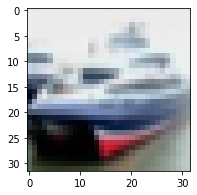

In [50]:
plt.imshow(X_test[1])

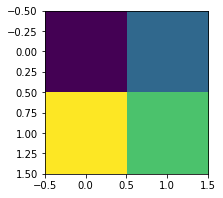

In [57]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
heatmap=grad_cam_plus(model,X_test[1])

#plt.imshow(show_imgwithheat(X_test[1],heatmap))
simage=show_imgwithheat(X_test[1],heatmap)
#plt.imshow(simage)


list of prediction and test_y

In [52]:
from array import *
def array_list(array_num):
    num_list = array_num.tolist() # list
    print(num_list)
  
# driver code
array_num = array('i', y_test) # array
array_list(array_num)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

In [38]:
from array import *
def array_list(array_num):
    num_list = array_num.tolist() # list
    print(num_list)
  
# driver code
array_num = array('i', predgray) # array

array_list(array_num)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 7, 0, 9, 4, 5, 9, 6, 5, 7, 8, 6, 7, 0, 5, 9, 4, 2, 7, 0, 9, 6, 6, 5, 4, 3, 9, 3, 7, 1, 9, 5, 5, 6, 7, 3, 0, 9, 3, 9, 7, 4, 4, 4, 0, 3, 8, 8, 4, 2, 3, 5, 7, 3, 6, 9, 6, 2, 9, 0, 3, 9, 2, 6, 8, 8, 0, 2, 0, 6, 5, 8, 8, 1, 9, 7, 2, 7, 3, 0, 8, 9, 0, 6, 5, 2, 4, 6, 6, 0, 0, 7, 4, 5, 6, 5, 1, 1, 6, 6, 1, 7, 6, 0, 2, 2, 1, 3, 0, 4, 3, 7, 8, 3, 1, 2, 8, 2, 8, 3, 3, 0, 6, 1, 8, 9, 9, 3, 9, 7, 2, 8, 6, 5, 6, 3, 8, 2, 6, 5, 5, 2, 8, 9, 6, 7, 0, 3, 3, 9, 3, 4, 2, 1, 1, 6, 9, 2, 8, 4, 5, 0, 7, 9, 3, 8, 9, 4, 3, 7, 3, 0, 0, 5, 2, 2, 0, 8, 4, 3, 3, 8, 4, 8, 0, 9, 6, 4, 8, 7, 7, 8, 5, 8, 8, 7, 1, 5, 0, 4, 7, 9, 2, 8, 5, 9, 8, 2, 7, 9, 8, 2, 7, 5, 9, 4, 3, 9, 8, 3, 5, 4, 5, 1, 3, 8, 8, 0, 4, 9, 3, 3, 1, 9, 8, 9, 0, 1, 9, 9, 2, 0, 5, 3, 9, 9, 4, 8, 6, 0, 8, 9, 6, 1, 3, 7, 0, 8, 4, 4, 7, 0, 3, 2, 6, 3, 8, 6, 8, 3, 4, 7, 9, 1, 6, 1, 0, 9, 1, 8, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 2, 6, 6, 6, 5, 2, 8, 0, 9, 2, 1, 4, 8, 6, 8, 0, 3, 0, 2, 7, 5, 3, 4, 3, 2, 5, 7, 9, 9, 5, 2, 6, 1, 3, 3, 

Incorrect labels finding

In [39]:
def find_incorrect_labels(classlabel):
  incrct = []
  count=0
  for i in range(len(X_test)):
    if count==2:
      break
    if (y_test[i] != predgray[i]) and y_test[i]==classlabel:
      incrct.append(i)
      count+=1
  return incrct

In [67]:
def plot(k):
    i,j=find_incorrect_labels(k)
    f = plt.figure()
    f.add_subplot(2,2, 1)
    plt.imshow(X_test[i])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,2, 2)
    heatmap=grad_cam_plus(model,X_test[i])
    simage=show_imgwithheat(X_test[i],heatmap)
    pred=predgray[i]
    plt.title(labels[pred])

    plt.imshow(simage)
    plt.axis('off')
  
    f.add_subplot(2,2, 3)
    plt.imshow(X_test[j])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,2, 4)
    heatmap=grad_cam_plus(model,X_test[j])
    simage=show_imgwithheat(X_test[j],heatmap)
    pred=predgray[j]
    plt.title(labels[pred])
    plt.imshow(simage)
    plt.axis('off')
    

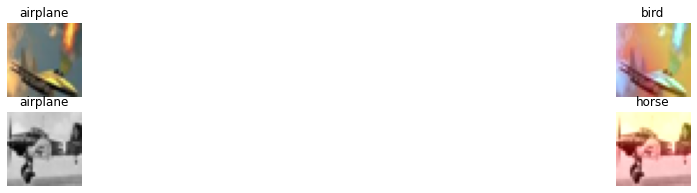

In [68]:
plot(0)

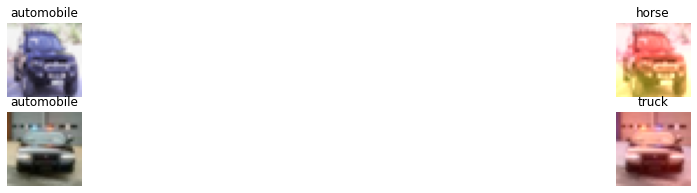

In [69]:
plot(1)

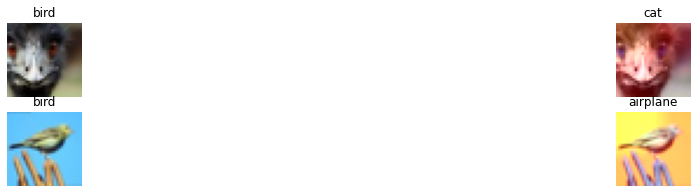

In [70]:
plot(2)

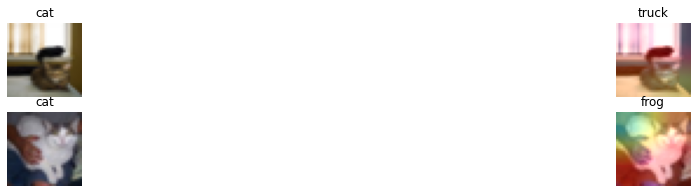

In [71]:
plot(3)

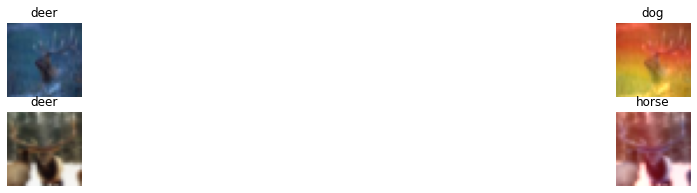

In [72]:
plot(4)

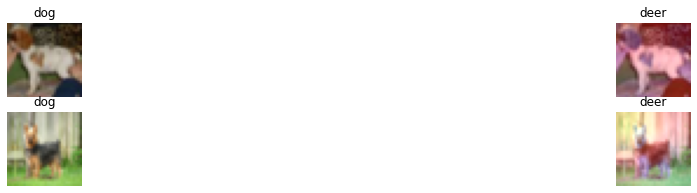

In [73]:
plot(5)

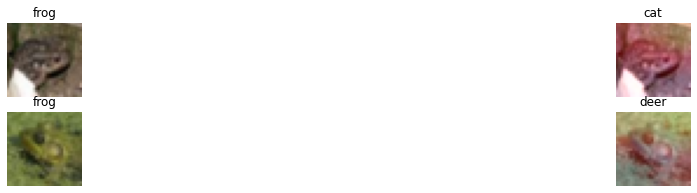

In [74]:
plot(6)

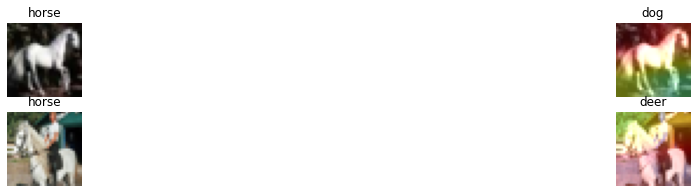

In [75]:
plot(7)

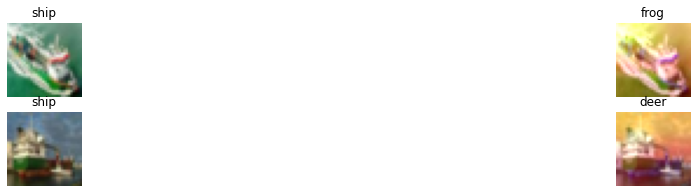

In [76]:
plot(8)

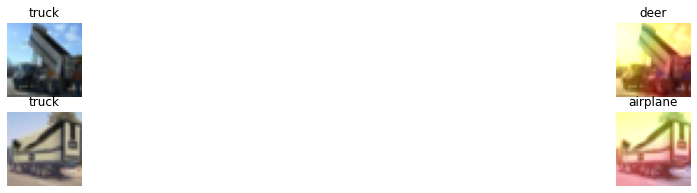

In [77]:
plot(9)

Correctly classified

In [80]:
def find_correct_labels(classlabel):
  crct = []
  count=0
  for i in range(len(X_test)):
    if count==2:
      break
    if (y_test[i] == predgray[i]) and y_test[i]==classlabel:
      crct.append(i)
      count+=1
  return crct

In [89]:
def plot(k):
    i,j=find_correct_labels(k)
    f = plt.figure()
    f.add_subplot(2,2, 1)
    plt.imshow(X_test[i])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,2, 2)
    heatmap=grad_cam_plus(model,X_test[i])
    simage=show_imgwithheat(X_test[i],heatmap)
    pred=predgray[i]
    plt.title(labels[pred])

    plt.imshow(simage)
    plt.axis('off')
    
    f.add_subplot(2,2, 3)
    plt.imshow(X_test[j])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,2, 4)
    heatmap=grad_cam_plus(model,X_test[j])
    simage=show_imgwithheat(X_test[j],heatmap)
    pred=predgray[j]
    plt.title(labels[pred])
    plt.imshow(simage)
    plt.axis('off')
   

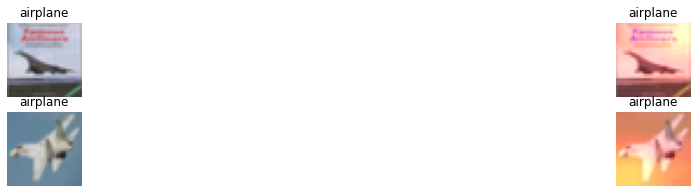

In [90]:
plot(0)

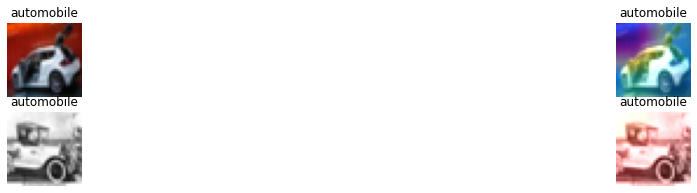

In [91]:
plot(1)

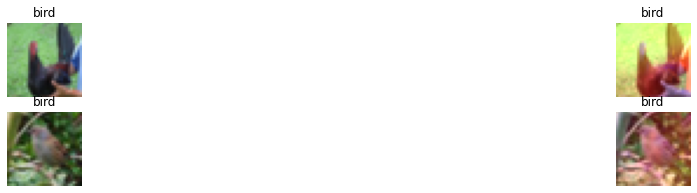

In [92]:
plot(2)

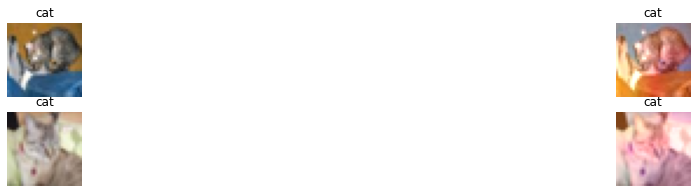

In [93]:
plot(3)

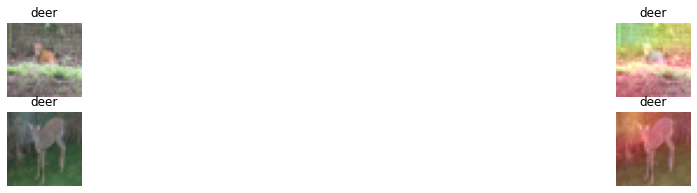

In [94]:
plot(4)

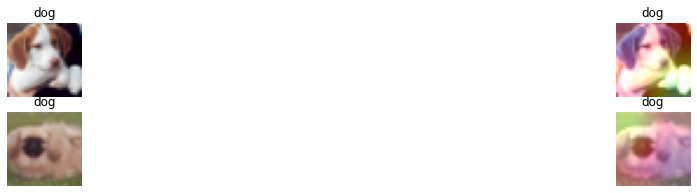

In [95]:
plot(5)

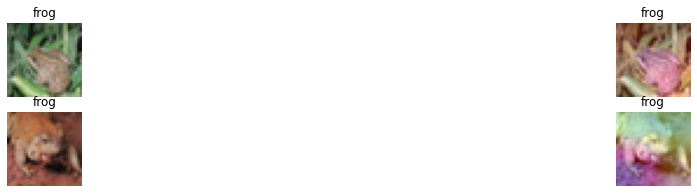

In [96]:
plot(6)

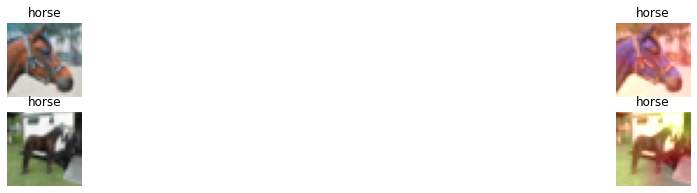

In [97]:
plot(7)

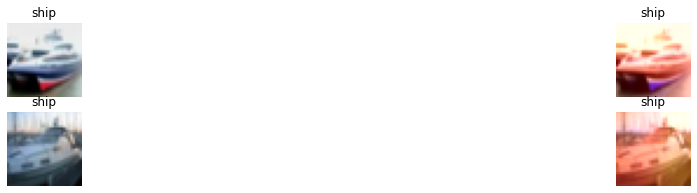

In [98]:
plot(8)

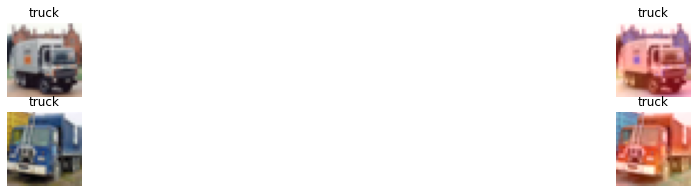

In [99]:
plot(9)